### Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Импорт данных и библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
from scipy import stats as st
from IPython.display import Image # Библиотека для отображения картинок

In [3]:
try:
    df = pd.read_csv('./datasets/games.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Неверные типы: 
1. Год не должен быть float 
2. Оценка пользователей и рейтинг не должны быть object
3. Не хватает данных в столбцах: Name, Year_of_Release, Genre, Critic_score, User_score, Rating

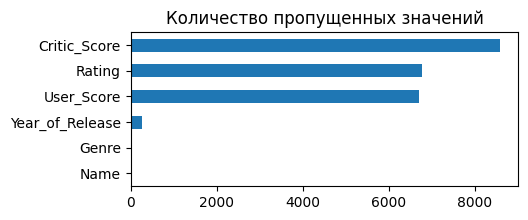

In [5]:
#Отдельно выведем кол-во недостающих значений
df_nulls = df.isna().sum()[df.isna().sum()>0]
df_nulls.sort_values().plot(kind ='barh', figsize=(5,2))
plt.title('Количество пропущенных значений')
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Правильно проанализировал данные в датафрейме, можно было еще использовать метод `describe()` или построить гистограммы для всех признаков датафрейма.

### Предобработка данных
#### Изменение названий столбцов

In [6]:
#df.columns = [x.lower() for x in df.columns]
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Правильно привел названия столбцов к нижнему регистру.
<font color = Blue>Я их в конце удалил, после того как понял, что это плохие строки

#### Изменение типов данных и работа с пропусками

In [7]:
#Для начала сохраним размер датафрейма
start_df = len(df)
print('Начальный размер датафрейма:', start_df)

Начальный размер датафрейма: 16715


In [8]:
df.duplicated().sum() # Явных дубликатов нет

0

In [9]:
#Посмотрим может название строк, где отсутствует название можно заполнить из других столбцов
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [10]:
#Т.к. в 2 строках отсутствует и жанр и название, удалим их
df = df.dropna(subset = ['name','genre'])

In [11]:
df.isna().sum()[df.isna().sum()>0]

year_of_release     269
critic_score       8576
user_score         6699
rating             6764
dtype: int64

In [12]:
#Посмотрим какими значениями заполнен столбец с годом выпуска
df['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [13]:
#Посмотрим на строки, где год = nan
df[df['year_of_release'].isna()].head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
719,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


In [14]:
df[(df['name'].str.contains(r'[0-9]{4}', regex=True,na=False))&(df['year_of_release'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
1650,NASCAR Thunder 2003,PS2,NaN,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E
2572,PES 2009: Pro Evolution Soccer,PSP,NaN,Sports,0.04,0.33,0.26,0.17,NaN,NaN,NaN
3486,Madden NFL 2002,XB,NaN,Sports,0.53,0.02,0.00,0.03,90.0,8.1,E
4775,NFL GameDay 2003,PS2,NaN,Sports,0.20,0.15,0.00,0.05,60.0,tbd,E
5156,NBA Live 2003,XB,NaN,Sports,0.31,0.04,0.00,0.01,82.0,8.8,E
5336,Tomb Raider (2013),PC,NaN,Action,0.06,0.25,0.00,0.04,86.0,8.5,M
5655,All-Star Baseball 2005,PS2,NaN,Sports,0.16,0.12,0.00,0.04,72.0,8.6,E


Визуально видно, что года соответствуют реальному выпуску игр

In [15]:
## Сделаем функцию, которая вытаскивает года из названия
#df_copy = df.copy()
#def parce_year(row):
#    if len(re.findall(r'[0-9]{4}',row['name']))>0: 
#        return re.findall(r'[0-9]{4}',row['name'])[0]
#    else: return row['year_of_release']

#df_copy['parced_year'] = df_copy.apply(parce_year, axis=1)
#df_copy['year_of_release']=df_copy['year_of_release'].fillna(df_copy['parced_year'])
#df_copy.isna().sum()[df_copy.isna().sum()>0]

Было 269 пропусков, осталось 252. Может быть такое, что год в названии не соответствует реальному выпуску игры, но они будут находиться не далеко от реального значения +- 1 год, поэтому такое заполнение считаю допустимым.

In [16]:
# Т.к. пропусков осталось менее 1% - удалим строки без года
df = df.dropna(subset=['year_of_release'])
# В дальнейшем мы неоднократно будем считать долю удаленных строк, поэтому сразу сделаем функцию
def deleted_percent (x):
    print ('{:2.2%}'.format(round(1-len(x)/start_df,3)))

deleted_percent(df)

1.60%


In [17]:
# Также сделаем функцию вывода оставшихся нулей
def current_nulls():
    print ('Оставшиеся пустые значения:')
    return df.isna().sum()[df.isna().sum()>0]
current_nulls()


Оставшиеся пустые значения:


critic_score    8461
user_score      6605
rating          6676
dtype: int64

In [18]:
df['year_of_release']=df['year_of_release'].astype(int)
#df.info()

In [19]:
print(df['critic_score'].unique())
df[(df['critic_score'].isna())&(df['user_score'].notna())].sort_values('name')


[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 41. 36. 31.
 27. 35. 26. 19. 28. 23. 24. 21. 17. 13.]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
11720,10 Minute Solution,Wii,2010,Sports,0.06,0.01,0.00,0.01,NaN,tbd,E
3898,100 All-Time Favorites,DS,2009,Puzzle,0.35,0.12,0.00,0.04,NaN,6.2,E
5725,1001 Touch Games,DS,2011,Action,0.11,0.16,0.00,0.04,NaN,tbd,E
11388,101-in-1 Sports Megamix,DS,2010,Sports,0.08,0.00,0.00,0.01,NaN,tbd,E10+
15288,18 Wheels of Steel: Extreme Trucker,PC,2009,Racing,0.00,0.02,0.00,0.00,NaN,8,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4664,pro evolution soccer 2011,PS2,2010,Sports,0.04,0.21,0.05,0.11,NaN,6.7,E
10843,thinkSMART,DS,2010,Misc,0.09,0.00,0.00,0.01,NaN,tbd,E
14453,thinkSMART FAMILY!,Wii,2010,Misc,0.03,0.00,0.00,0.00,NaN,tbd,E
16494,thinkSMART: Chess for Kids,DS,2011,Misc,0.01,0.00,0.00,0.00,NaN,tbd,E


* У нас 1889 строк, где нет значения critic score, но есть user score
* Нужно посмотреть позже насколько они схожи и есть ли зависимость между ними
* В столбце user score есть значение tbd, поэтому сначала разберемся с ним

In [20]:
df['user_score'].value_counts()[df['user_score'].value_counts()>200]



tbd    2376
7.8     322
8       285
8.2     276
8.3     252
7.5     249
8.5     247
7.9     246
8.1     237
7.7     236
7.3     232
8.4     221
7       216
7.4     213
7.6     213
8.6     209
Name: user_score, dtype: int64

* 2376 значений TBD
* To Be Determined, то есть "Будет определено". Очень часто подобное сокращение можно встретить в анонсах компьютерных игр в графе "Дата выхода" на портале metacritic пользователям запрещено ставить оценки до релиза, поэтому заполнить эти поля мы не сможем. 

In [21]:
#Посмотрим есть рейтинг критиков по tbd
df[df['user_score']=='tbd'].head(8)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.00,0.18,NaN,tbd,E
726,Dance Dance Revolution X2,PS2,2009,Simulation,1.09,0.85,0.00,0.28,NaN,tbd,E10+
821,The Incredibles,GBA,2004,Action,1.15,0.77,0.04,0.10,55.0,tbd,E
881,Who wants to be a millionaire,PC,1999,Misc,1.94,0.00,0.00,0.00,NaN,tbd,E


Несколько наблюдений: 
* Есть поля, где user_score = TBD и при этом есть оценка критиков произведена.
* Заполнять пропуски в столбце user_score на основании других столбцов считаю некорректным логически.
* Но для уверенности в этом посмотрим насколько сильно коррелируют отзывы критиков и отзывы пользователей, где есть и то и другое

In [22]:
df_clean=df[df['user_score']!='tbd'].dropna(subset=['critic_score','user_score'])
df_clean['user_score']=df_clean['user_score'].astype(float)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6894 entries, 0 to 16705
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             6894 non-null   object 
 1   platform         6894 non-null   object 
 2   year_of_release  6894 non-null   int32  
 3   genre            6894 non-null   object 
 4   na_sales         6894 non-null   float64
 5   eu_sales         6894 non-null   float64
 6   jp_sales         6894 non-null   float64
 7   other_sales      6894 non-null   float64
 8   critic_score     6894 non-null   float64
 9   user_score       6894 non-null   float64
 10  rating           6826 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 619.4+ KB


В этом блоке я выяснил, что даже после удаления TBD и пустых строк значения в столбце user score не были float, поэтому остаток я преобразовал.

In [23]:
#Теперь можем посчитать коэффициент корреляции
df_clean[['critic_score','user_score']].corr()

,critic_score,user_score
critic_score,1.000000,0.579671
user_score,0.579671,1.000000


Коэффициент корреляции низкий, хотя небольшая связь присутствует. 
Т.к. заполнить значения TBD не получится, превратим их в Nan

In [24]:
df['user_score']=df['user_score'].replace('tbd',np.NaN).astype(float)
current_nulls()

Оставшиеся пустые значения:


critic_score    8461
user_score      8981
rating          6676
dtype: int64

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Именно так, все верно.
</div>

Количество NA увеличилось, зато мы точно значем, что оставшиеся значения в формате Float и пригодны для анализа.  
Разберемся с рейтингом

In [25]:
df['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Значения представлеты в формате string, а технология определения этого рейтинга не известна, поэтому оставим как есть

In [26]:
# Т.к. столбец рейтинг ESRB формата String, заполним пропуски значением unnamed, возможно в дальнейшем сможем сделать дополнительные выводы по этому столбцу.
df['rating']=df['rating'].fillna('unrated')
df['rating'].unique()

array(['E', 'unrated', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

<div class="alert alert-success">
<h2> Комментарий ревьюера V3<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Отлично! Теперь в пункте с выявлением зависимости от рейтинга ESRB можно увидеть важные зависимости.

#### Проверка аномальных значений

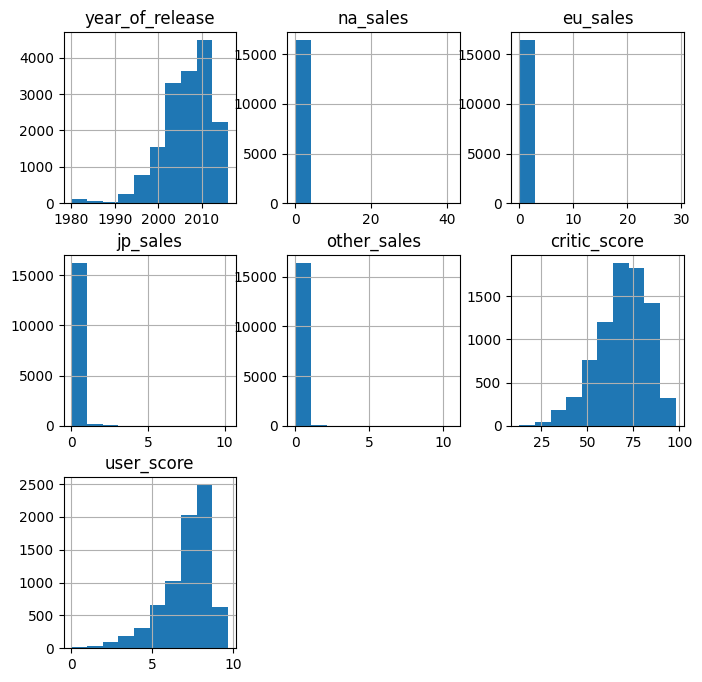

In [27]:
df.hist(figsize=(8,8))
plt.show()

Стоит отдельно посмотреть столбцы с продажами.
По метрикам с оценками распределение пригодно для анализа.
В годе выпуска видно, что до 1990 года было мало игр, поэтому тоже посмотрим их детальнее.

In [28]:
pd.concat([df.describe(),df.quantile([0.01,0.02,0.98,0.99], numeric_only= True)]).style.format('{:.2f}')

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16444.00,16444.00,16444.00,16444.00,16444.00,7983.00,7463.00
mean,2006.49,0.26,0.15,0.08,0.05,68.99,7.13
std,5.88,0.82,0.51,0.31,0.19,13.92,1.50
min,1980.00,0.00,0.00,0.00,0.00,13.00,0.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00,6.40
50%,2007.00,0.08,0.02,0.00,0.01,71.00,7.50
75%,2010.00,0.24,0.11,0.04,0.03,79.00,8.20
max,2016.00,41.36,28.96,10.22,10.57,98.00,9.70
0.010000,1987.00,0.00,0.00,0.00,0.00,31.82,2.36
0.020000,1993.00,0.00,0.00,0.00,0.00,36.00,3.00


Из столбцов с продажами и оценками аномалии убирать не будем, т.к. явных аномалий тут нет, а редкие значения имеют право на существование, т.к. это оценки и продажи.  
Есть смысл убрать очень старые игры, которые выпускались до 1993 года. По ним мало оценок и статистика может быть некорректной  
Было предположение, что кто-то из пользователей могут указать миллионы в миллионах, но судя по максимуму таких нет.


In [29]:
df = df[df['year_of_release']>=1993]
deleted_percent(df)

3.40%


<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Правильное решение, молодец!

##### Добавление столбца с суммой

In [30]:
df['sales_total']=df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unrated,31.38
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80


<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Абсолютно верно рассчитал суммарные продажи.

##### Выводы по итогам обработки пропусков
* По итогам обработки данных мы сократили размер датафрейма на 3.4%, что вполне допустимо.
* Часть данных удалось вытащить из названия игры, что может вносить определенную долю погреншности,  но т.к. таких строк всего 15, +- год от даты выхода игры не исказит анализ
* Столбец "Год релиза" удалось привести к целочисленному формату.
* В столбцах с рейтингом пользователей заменили TBD на NaN
* Удалили из Датасета очень старые игры. т.к. по ним было очень мало оценок.

### Исследовательский анализ данных

#### Динамика выпуска игр по годам

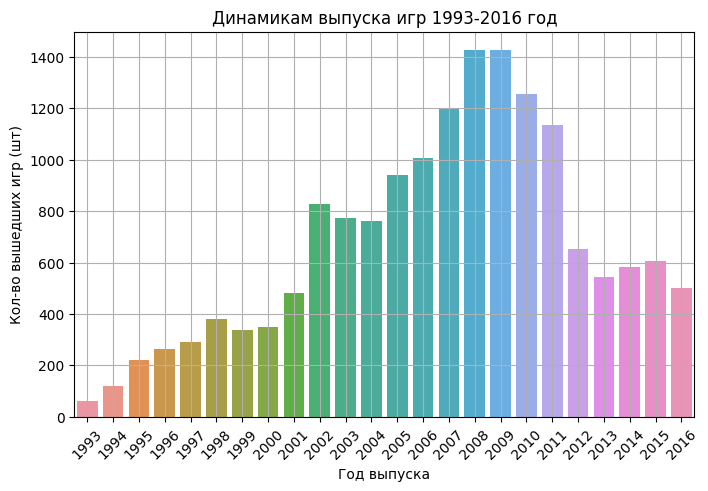

In [31]:
df_games_by_year = df.groupby('year_of_release',as_index=False)['name'].count()
plt.figure(figsize=(8,5))
ax = sns.barplot(x=df_games_by_year['year_of_release'],y=df_games_by_year['name'])
plt.xticks(rotation=45)
plt.grid(True)
plt.ylabel('Кол-во вышедших игр (шт)')
plt.xlabel('Год выпуска')
plt.title('Динамикам выпуска игр 1993-2016 год')
plt.show()

* Пик выпуска игр пришелся на 2008-2009 год. Кол-во выпущенных игр составило более 1400 шт.
* До этого момента игровая индустрия развивалась, и с 2005 года. 
* Со временем игры требовали больше инвестиций, ведь они становились сложнее. Команда из 6 разработчиков уже не могла выпустить игру ААА класса  
* К концу 2008 года работу потеряли 2,6 миллиона американцев. По данным Бюро трудовой статистики США, к февралю 2010 года количество трудоустроенного населения сократилось на 8,8 миллиона человек по сравнению с данными до кризиса. В первый же год кризиса банки конфисковали ипотечное жильё у примерно миллиона американцев. Миллионы граждан в США потеряли работу и им стало не до развлечений.
* Инвесторам стало не выгодно инвестировать в игры, что одновременно повлияло и на количество игр и на штат разработчиков.
* После 2011 года колебания по продажам уменьшились, ведь еще с 2000 года игровая индустрия была разделена между 20 ведущими компаниями, которые ограничивали бюджет и кол-во игр, которые нужно выпускать на определенный период.  
<font color = blue> Ответ на вопрос "Важны ли данные за все периоды"</font>: 
* В нашем датасете мы исключили игры, которые выпускались до 1993 года в виду их количества. Но посмотрев на то, как менялись игры в предыдущие и будущие периоды, мы могли бы получить и выявить новые следствия и тренды.  
Примечание: Мы не брали в расчет количество игр по разным платформам, то есть выпуском одной игры считаем ее выход в независимости от платформ, на которых она вышла

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Полностью согласен с написанными тобой наблюдениями. Продолжай в том же духе!

#### Динамика продаж по платформам

In [32]:
px.histogram(df,x='year_of_release',color = 'platform',width=800)

* Из гистограммы видно, что 1994 по 2001 год популярной была PS
* Чуть меньший вес в этот период имела приставка N64
* С 2001 года лидером по кол-ву игр была PS2
В целом на гистограмме отчетливо виден жизненный цикл каждой из платформ.  
Также из гистограммы примерно видно, что средний срок жизни любой платформы 5-6 лет
Есть смысл отдельно посмотреть ТОП 5

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> И снова все верно, молодец!

In [33]:
# Найдем топ 5 платформ за все время по количеству игр
print ('Топ 10 платформ и количество выпущенных на них игр')
df_top10=df.groupby('platform', as_index=False)['name'].count().sort_values('name', ascending=False).head(10)
top10 = df_top10['platform'].to_list()
df_top10

Топ 10 платформ и количество выпущенных на них игр


,platform,name
14,PS2,2127
3,DS,2120
15,PS3,1306
24,Wii,1286
26,X360,1232
17,PSP,1193
13,PS,1190
11,PC,950
5,GBA,811
27,XB,803


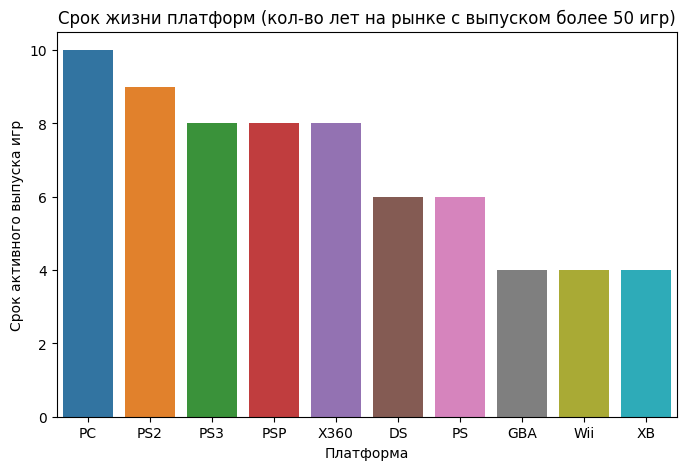

In [34]:
# Отбираем из ДФ данные по ТОП 10, считаем сколько игра было выпущено по платформе за год.
df_top_10_grouped = df[df['platform'].isin(top10)].groupby(['platform','year_of_release'],as_index=False)['name'].count()
df_top_10_grouped = df_top_10_grouped[df_top_10_grouped['name']>50]
# Добавляем столбец с минимальным годом, при этом оставляем количество выпущенных игр.
df_top_10_grouped['first_year']=df_top_10_grouped.groupby('platform')['year_of_release'].transform('min')
# Высчитываем колчество лет, сколько в среднем жила платформа
df_top_10_grouped['year_number']=df_top_10_grouped['year_of_release']-df_top_10_grouped['first_year']
# Будем считать, что если за год на топ платформе вышло менее 50 игр, то она уже не популярна.
df_max_year = df_top_10_grouped.groupby('platform', as_index = False)['year_number'].max()\
    .sort_values('year_number',ascending = False)
plt.figure(figsize=(8,5))
sns.barplot(x = df_max_year['platform'], y = df_max_year['year_number'])
plt.title('Срок жизни платформ (кол-во лет на рынке с выпуском более 50 игр)')
plt.xlabel('Платформа')
plt.ylabel('Срок активного выпуска игр')
plt.show()


* PC и PS2 по сути уникальные платформы, PC в принципе уникальное устройство, а PS2 - культовая приставка, которая произвела революцию в свое время.
* Остальные приставки выпускают более 50 игр в год  в течение 4-6 месяцев
* Стоит отдельно выделить Бренды Playstation и Xbox. Эта группа является несомненным лидером, и их срок жизни выше, чем у других

In [35]:
print ('Средний срок жизни топ платформы: ',df_max_year['year_number'].mean())
print ('Средний срок жизни топ платформы без PC и PS2: ',df_max_year[~df_max_year['platform'].isin(['PC','PS2'])]['year_number'].mean())

Средний срок жизни топ платформы:  6.7
Средний срок жизни топ платформы без PC и PS2:  6.0


<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Именно так, все верно.

#### Как часто появляются новые платформы

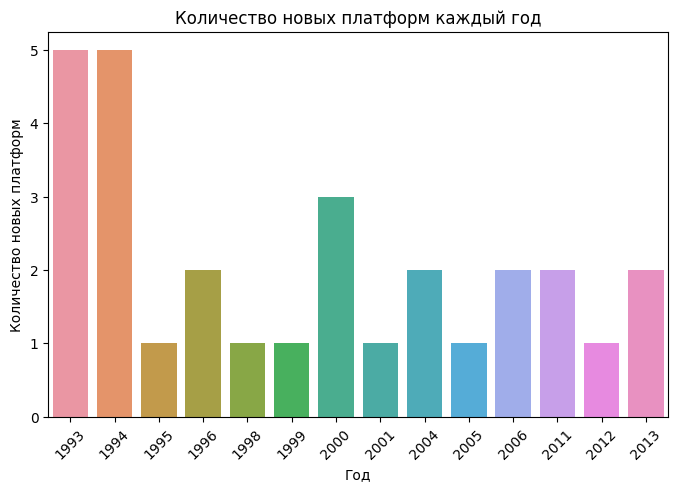

In [36]:
# Посмотрим сколько платформ появлялось в каждый год
# Расчет года, когда появилась платформа
df_new_platforms = df[['platform','year_of_release']].groupby(['platform','year_of_release'],as_index=False).first()
df_new_platforms['min_year'] = df_new_platforms.groupby('platform')['year_of_release'].transform('min')
# В сгруппированной таблице оставим только строки, где год появления совпал с первым годом. 
# Посчитав количество строк получаем сколько новых платформ появилось в каждый год
df_new_platforms = (df_new_platforms[df_new_platforms['min_year']==df_new_platforms['year_of_release']]
    .groupby('year_of_release',as_index=False)['min_year']
    .count())
plt.figure(figsize=(8,5))
sns.barplot(x=df_new_platforms['year_of_release'], y = df_new_platforms['min_year'])
plt.title('Количество новых платформ каждый год')
plt.xticks(rotation=45)
plt.ylabel('Количество новых платформ')    
plt.xlabel('Год')
plt.show()



* Чаще всего в год появляется одна новая платформа
* 93-94 год выходило по 5 платформ, если считать, что датасет включает в себя все платформы за все года
* Стоит отметить, что в последнее время новые платформы стали выходить реже. С 2013 по 2015 год ни одной новой платформы не вышло.

Примечение: Новые поколения старых приставок считаем новыми.

#### Прогнозирование продаж на 2017 год и тренды
* Ранее мы выявнили, что в 2010 году произошел кризис, из графика выше видно, что после этого периода появление игр находилось на одном уровне
* Оптимальным периодом определим 5 последних лет, когда внешние факторы оказывали минимальное плияние на выпуск игр, помимо этого 5 лет - близок к среднему периоду выхода/ухода новых платформ


<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Верное решение, этот срок позволит сохранить исторические зависимости и будет отражать совеременные тенденции.

In [37]:
px.histogram(df,x='year_of_release',color = 'platform',width=800)

Для того, чтобы определить тренды, вернемся к графику, показанному ранее.  
1. Мы знаем, что Самые "Долгоживущие" платформы - XBOX и PS. Как правило, игры к ним активно выпускаются на протяжении 8 лет, новое поколение выходит примерно раз в 5 лет.
2. Актуальные платформы этих брендов - XBOX One PS4 появились примерно в 2014 году, в период 2015-2017 стоит ожидать, что выйдут новые поколения этих платформ, при этом и старые не уйдут с рынка.
3. 3DS находится на спаде, и скорее всего скоро уйдет с рынка как и другие платформы других брендов.
4. В целом мы видим, что PS и XBOX в актуальный период еще сильнее вытесняют другие платформы, поэтому Основной упор нужно сделать на них.
5. При этом PS4 и XBOX one стоит продолжать поддерживать еще на протяжении 2-3 лет.
6. Отдельным кейсом стоит рассмотреть игры для PC. Т.к. эта платформа видоизменяется и по сути с выходом нового "железа" обновляет саму себя, нужно продолжать выпускать игры для нее, т.к. это стабильный доход, который сохраняется на протяжении почти всего жизненного цикла.

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Согласен с тобой, все так.

#### Продажи игр по платформам

Text(0.5, 9.444444444444438, 'Продажи (млн)')

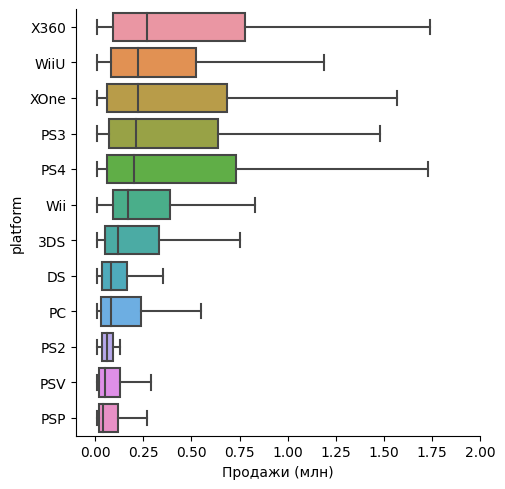

In [42]:
# Посмотрим зависимость продаж игр от платформы
# Переходя к следующим блокам сделаем срез по актуальному периоду
df = df[df['year_of_release']>2010]
median_order = df.groupby('platform')['sales_total'].median().sort_values(ascending=False).index
sns.catplot(data = df, x =  'sales_total', y = 'platform',kind = 'box', orient='h', order=median_order, fliersize = 0)
plt.xlim(-0.1,2)
plt.xlabel('Продажи (млн)')
#plt.ylabel('Платформа')
#plt.title('Продажи игр по платформам')
#plt.show()

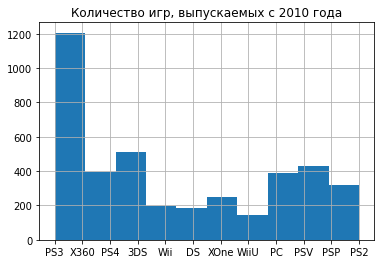

In [ ]:
# Полезно будет сразу смотреть на количество игр по платформам
df['platform'].hist()
plt.title('Количество игр, выпускаемых с 2010 года')
plt.show()

Данных по каждой платфорорме достаточно для корректного сравнения их между собой

Выводы:
1. Самая интересная платформа по продажам - X360. В нем ного бестселлеров, да и медиана выше, чем у остальных, что говорит о том, что даже игра не ААА-класса может иметь хорошую выручку. При этом актуальный период почти полностью совпал с пиком продаж В настойщий момент платформа идет на спад.
2. Далее идут 4 платформы с отличными продажами: WiiU, Xone, PS3, PS4
3. Остальные платформы уступают по продажам,  
4. По PC хоть медиана и низкая, есть проекты с хорошими продажами. То же самое можно сказать про Wii и 3Ds
Примечание:   
Для корректного анализа надо брать по каждой игре тоже актуальный период, чтобы не получилось, что топовая игра вышла на конец периода датафрейма, и у нас нет по ней продаж... Технически это можно вычислить, но не в рамках этой задачи.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера V1<a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
Нужно рассмотреть платформы только за актуальный период (последние 5 лет). 
    
Все пункты ниже тоже нужно рассматривать на актуальном датафрейме.  
<font color = blue>Исправлено

<div class="alert alert-success">
<h2> Комментарий ревьюера V3<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Все корректно доработал, продолжай в том же духе!

#### Зависимость продаж от отзывов и ревью
Для того, оценить плияние пропусков на продажи одной из платформ, посмотрим, где у нас сохранилось большинство строк

In [ ]:
df_top10 = df[df['platform'].isin(top10)]
nul_count = []
for x in df_top10['platform'].unique():
    nul_count.append(
        [x, df_top10[df_top10['platform']==x]['critic_score'].isna().sum(), 
        df_top10[df_top10['platform']==x]['user_score'].isna().sum(), len(df_top10[df_top10['platform']==x])])
df_na = pd.DataFrame(columns = ['platform','crit_na','user_na','total'],data = nul_count)
df_na['na_perc_crit']=df_na['crit_na']/df_na['total']
df_na['na_perc_user']=df_na['user_na']/df_na['total']

df_na.sort_values('na_perc_crit')

,platform,crit_na,user_na,total,na_perc_crit,na_perc_user
4,PC,100,82,389,0.257069,0.210797
1,X360,202,134,498,0.405622,0.269076
0,PS3,359,291,708,0.507062,0.411017
2,Wii,149,137,197,0.756345,0.695431
3,DS,164,171,184,0.891304,0.929348
5,PSP,298,296,312,0.955128,0.948718
6,PS2,7,4,7,1.000000,0.571429


Для анализа возьмем 3 платформы, где доля незаполненных строк менее 51%. Хорошие кандидаты - PC, X360 и PS3. Помимо этого по ним есть наиболее полная картина, т.к. это платформы с большим сроком существования.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера V1<a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
Необходимо пересмотреть зависимости после того, как ты будешь использовать актуальный датафрейм.  
<font color = blue>Готово в итоге вместо PS2 смотрим PS3

<div class="alert alert-success">
<h2> Комментарий ревьюера V3<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Все правильно, молодец!

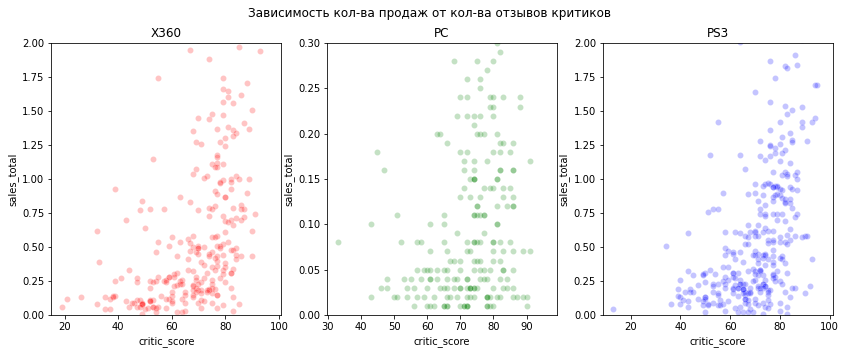

In [ ]:
df_review = df_top10[df_top10['platform'].isin(['PC','X360','PS3'])].dropna(subset=['critic_score','user_score'])
fig, axes = plt.subplots(1, 3, figsize=(14,5))
fig.suptitle('Зависимость кол-ва продаж от кол-ва отзывов критиков')
axes[0].set_title('X360')
axes[1].set_title('PC')
axes[2].set_title('PS3')
ax = sns.scatterplot(
    ax = axes[0], 
    x=df_review[df_review['platform']=='X360']['critic_score'],
    y=df_review[df_review['platform']=='X360']['sales_total'],
    color = 'red', alpha = 0.23)
ax1 = sns.scatterplot(
    ax = axes[1], 
    x=df_review[df_review['platform']=='PC']['critic_score'],
    y=df_review[df_review['platform']=='PC']['sales_total'],color = 'green', 
    alpha = 0.23)
ax2 = sns.scatterplot(
    ax = axes[2], 
    x=df_review[df_review['platform']=='PS3']['critic_score'],
    y=df_review[df_review['platform']=='PS3']['sales_total'],
    color = 'blue', alpha = 0.23)
ax.set_ylim(0,2)
ax1.set_ylim(0,0.3)
ax2.set_ylim(0,2)
plt.show()


* Видна линейная зависимость количества продаж от отзывов критиков. Рост оценки приводит к росту продаж.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера V1<a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
Нужно написать что это за зависимость.  
<font color = blue> На актуальных цифрых линейная связь стала просматриваться лучше.

<div class="alert alert-success">
<h2> Комментарий ревьюера V3<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Правильный вывод, оценки критиков в некоторой степени влияют на продажи игр.

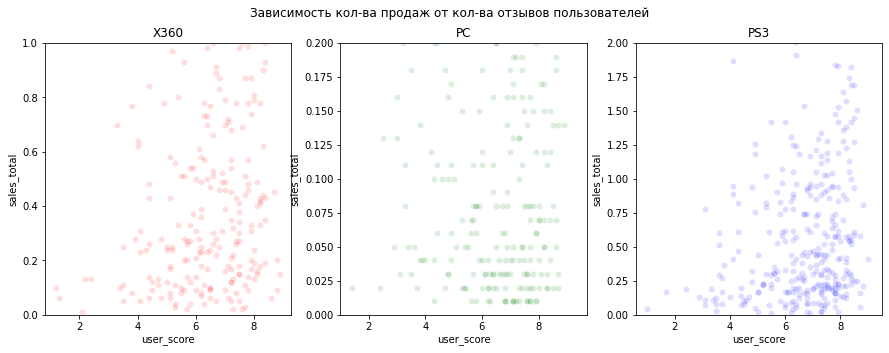

In [ ]:
df_review = df_top10[df_top10['platform'].isin(['PC','X360','PS3'])].dropna(subset=['critic_score','user_score'])
fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Зависимость кол-ва продаж от кол-ва отзывов пользователей')
axes[0].set_title('X360')
axes[1].set_title('PC')
axes[2].set_title('PS3')
ax = sns.scatterplot(ax = axes[0], x=df_review[df_review['platform']=='X360']['user_score'],y=df_review[df_review['platform']=='X360']['sales_total'],color = 'red', alpha = 0.13)
ax1 = sns.scatterplot(ax = axes[1], x=df_review[df_review['platform']=='PC']['user_score'],y=df_review[df_review['platform']=='PC']['sales_total'],color = 'green', alpha = 0.13)
ax2 = sns.scatterplot(ax = axes[2], x=df_review[df_review['platform']=='PS3']['user_score'],y=df_review[df_review['platform']=='PS3']['sales_total'],color = 'blue', alpha = 0.13)
ax.set_ylim(0,1)
ax1.set_ylim(0,0.2)
ax2.set_ylim(0,2)
plt.show()
    

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера V1<a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
Также необходимо подробнее расписать зависимость от оценок пользователей.
<font color = blue>  
Добавил

А вот оценки пользователей не так явно влияют на продажи.  
Связь есть, но не такая сильная как у оценок критиков.  
Выделю PS3, на ней зависимость Лучше прослеживается.

<div class="alert alert-success">
<h2> Комментарий ревьюера V3<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> И снова все верно, молодец!

In [ ]:
#Посчитаем коэффициенты корреляции для X360
for x in df_review['platform'].unique():
    print ('Корреляция для: {}'.format(x))
    display(df_review[df_review['platform']==x][['user_score','critic_score','sales_total']]\
        .corr()['sales_total']\
        .to_frame()\
        .style.background_gradient('coolwarm')\
        .format('{:.2f}'))

Корреляция для: PS3


,sales_total
user_score,0.03
critic_score,0.38
sales_total,1.00


Корреляция для: X360


,sales_total
user_score,0.02
critic_score,0.39
sales_total,1.00


Корреляция для: PC


,sales_total
user_score,-0.06
critic_score,0.31
sales_total,1.00


Мы видим, связи user_score с sales почти нет. Оценки пользователей не влияют на продажи.
В случае с PC есть даже небольшая обратная связь...
Коэффициент корреляции по критикам составляет чуть больше 0.3, это говорит нам, что в некоторых случаях зависимость есть, но сказать, что она линейная мы не можем

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера V1<a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
Нужно отдельно взять популярную платформу и выявить для неё корреляции от оценок пользователей и критиков. Также затем отдельно взять две-три другие платформы и отдельно для них рассмотреть зависимости.  
<font color = blue> Готово, вывел корреляцию для 3 популярных платформ

<div class="alert alert-success">
<h2> Комментарий ревьюера V3<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Видно, что для всех популярных платформ наблюдается аналогичная ситуация.

#### Распределение игр по жанрам

In [ ]:
fig = px.histogram(df,x='genre',color='genre', title='Расрпеделение игр по жанрам')
fig.update_traces(showlegend=False)

В актуальный период самый популярный жанр - экшн, за период вышло более 1200 игр.  
Следующим блоком идут РП игры, игры категории "Разное", Спорт и Adventure.  
Чуть менее - шутеры
Остальные жанры продаются сильно меньше

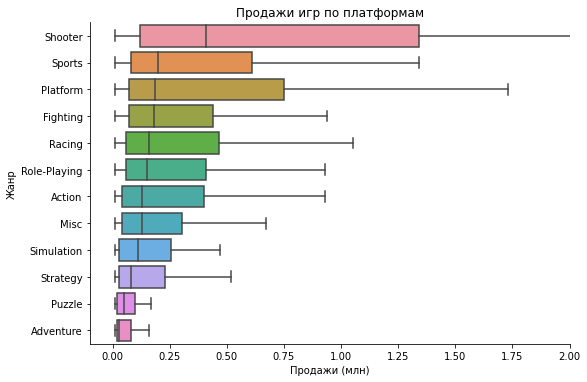

In [ ]:
median_order = df.groupby('genre')['sales_total'].median().sort_values(ascending=False).index
sns.catplot(data = df,x='sales_total', y = 'genre',kind = 'box', aspect=19/12,order=median_order, fliersize = 0)
plt.xlim(-0.1,2)
plt.xlabel('Продажи (млн)')
plt.ylabel('Жанр')
plt.title('Продажи игр по платформам')
plt.show()

А вот результат по продажам сильно отличается.  
* Несомненный лидер - Шутеры - очень хороошо продаются.
* Далее - Sports и Platform, у них высокие медианные значения, и игр, которые имеют хорошие сборы тоже много.
* А вот Puzzle и Adventure продаются слабо.  
Но здесь стоит сделать оговорку. Часто игры относят сразу к нескольким жанрам. Adventure может иметь низкий показатель по продажам, потому некоторые ТОП игры отнесли к жанру action или Shooter.


<div class="alert alert-warning">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> Все верно рассмотрел, нужно только изменить вывод после того, как ты рассмотришь актуальный период.  
<font color = blue> Готово

<div class="alert alert-success">
<h2> Комментарий ревьюера V3<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Полностью согласен с твоим выводом, так держать!

### Портрет пользователя (na,eu,jp)

#### Топ 5 платформ

In [ ]:
#Т.к. портрет нужен актуальный, и мы планируем актуальную рекламу, возьмем данные за последние 5 лет (средний цикл)
#Помимо этого в последние 5 лет кортина наиболее статичная
df_actual=df[df['year_of_release']>2010]
america_top = df_actual.groupby('platform',as_index=False)['na_sales'].sum().sort_values('na_sales', ascending=False)
america_top['perc_plat']=america_top['na_sales']/america_top['na_sales'].sum()
europe_top = df_actual.groupby('platform',as_index=False)['eu_sales'].sum().sort_values('eu_sales', ascending=False)
europe_top['perc_plat']=europe_top['eu_sales']/europe_top['eu_sales'].sum()
japan_top = df_actual.groupby('platform',as_index=False)['jp_sales'].sum().sort_values('jp_sales', ascending=False)
japan_top['perc_plat']=japan_top['jp_sales']/japan_top['jp_sales'].sum()
america_top['country']='NA'
europe_top['country']='EU'
japan_top['country']='JP'


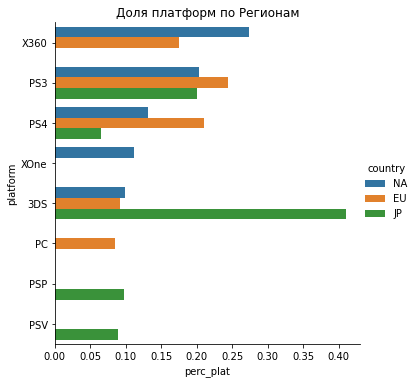

In [ ]:
df_res = pd.concat([america_top.head(5),europe_top.head(5),japan_top.head(5)]).fillna(0)
df_res
sns.catplot(data = df_res, x = 'perc_plat',y='platform', hue='country', kind = 'bar')
plt.title('Доля платформ по Регионам')
plt.show()

* В X360 в Японии почти не ирают, в Aмерике - любимая платформа, в Японии приставка не входит в топ 5.
* PS3, PS4 Больше всего популярны в Европе, в Америке и Японии чуть ниже.
* XBOX One вошел в топ только в Америке (любят там продукцию Майкрософт)
* А вот 3DS несомненный лидер в Японии
* Европа все еще активно играет на ПК, а в Америке и Европе уже перешли не приставки
* PSP и PSV вошли в топ только в Японии 

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Все верно, молодец! Согласен с описанными тобой выводами.

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=america_top['platform'].head(5), values=america_top['perc_plat'].head(5), name="GHG Emissions"),1, 1)
fig.add_trace(go.Pie(labels=europe_top['platform'].head(5), values=europe_top['perc_plat'].head(5), name="GHG Emissions"),1, 2)
fig.add_trace(go.Pie(labels=japan_top['platform'].head(5), values=japan_top['perc_plat'].head(5), name="GHG Emissions"),1, 3)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Портрет пользователя по топ 5 платформам игр",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='NA', x=0.13, y=0.5, font_size=20, showarrow=False),
                 dict(text='EU', x=0.50, y=0.5, font_size=20, showarrow=False),
                 dict(text='JP', x=0.87, y=0.5, font_size=20, showarrow=False)],bargap = 0.3)
fig.show()

NameError: name 'make_subplots' is not defined

Первый график более информативен, но Маркетологам такой может тоже пригодиться, в нем более наглядно выражен именно портрет потребителя.

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Отлично, что построил круговые диаграммы, они информативнее, видно доли разных платформ.

#### Топ 5 жанров

In [ ]:
america_top = df_actual.groupby('genre',as_index=False)['na_sales'].sum().sort_values('na_sales', ascending=False)
america_top['perc_plat']=america_top['na_sales']/america_top['na_sales'].sum()
europe_top = df_actual.groupby('genre',as_index=False)['eu_sales'].sum().sort_values('eu_sales', ascending=False)
europe_top['perc_plat']=europe_top['eu_sales']/europe_top['eu_sales'].sum()
japan_top = df_actual.groupby('genre',as_index=False)['jp_sales'].sum().sort_values('jp_sales', ascending=False)
japan_top['perc_plat']=japan_top['jp_sales']/japan_top['jp_sales'].sum()
america_top['country']='NA'
europe_top['country']='EU'
japan_top['country']='JP'

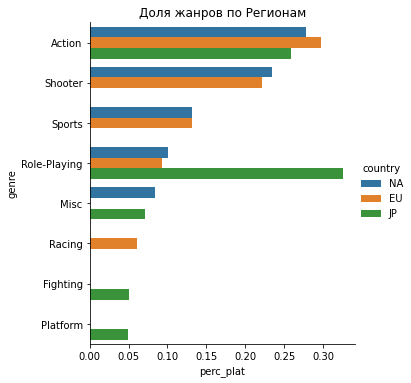

In [ ]:
df_res = pd.concat([america_top.head(5),europe_top.head(5),japan_top.head(5)]).fillna(0)
df_res
sns.catplot(data = df_res, x = 'perc_plat',y='genre', hue='country', kind = 'bar')
plt.title('Доля жанров по Регионам')
plt.show()

* Экшн популярен везде
* Шутеры актуальны в Америке и Европе, а в Японии не входит в топ 5.
* В Японии не любят спортивные игры
* В Японии более 30% продаж - РП игры, что заметно выше, чем в других регионах.
* Стоит отметить, что в Европе по-прежнему популярны гонки,
* В Японии - Файтинги и Платформенные игры

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Снова все верно, продолжай в том же духе!

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=america_top['genre'].head(5), values=america_top['perc_plat'].head(5), name="GHG Emissions"),1, 1)
fig.add_trace(go.Pie(labels=europe_top['genre'].head(5), values=europe_top['perc_plat'].head(5), name="GHG Emissions"),1, 2)
fig.add_trace(go.Pie(labels=japan_top['genre'].head(5), values=japan_top['perc_plat'].head(5), name="GHG Emissions"),1, 3)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Портрет пользователя по топ 5 жанрам игр",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='NA', x=0.13, y=0.5, font_size=20, showarrow=False),
                 dict(text='EU', x=0.50, y=0.5, font_size=20, showarrow=False),
                 dict(text='JP', x=0.87, y=0.5, font_size=20, showarrow=False)],bargap = 0.3)
fig.show()

#### Влияние ESRB на продажи в регионе

In [ ]:
#Т.к. нас просят посмотреть продажи по регионам, посмотрим сколько "Оцененных" игр есть в каждом из регионов.
df_esrb = df_actual.dropna(subset=['rating'])
df_esrb['rating'].value_counts()

unrated    1708
M           622
E           618
T           616
E10+        456
EC            1
RP            1
Name: rating, dtype: int64

Рейтингов EC и RP почти нет, учтем это в дальнейшем. А вот категория unrated имела 1708 пропусков по актуальному периоду

In [ ]:
df_esrb[(df_esrb['na_sales']>0)].groupby('rating')['na_sales'].count().to_frame()

,na_sales
rating,
E,503
E10+,408
M,570
T,482
unrated,469


Видно, что в Америке актуальны 4 оценки из рейтинга, в анализе будем обращать внимание на них, доля unrated составляет около 20%

In [ ]:
df_esrb[(df_esrb['eu_sales']>0)].groupby('rating')['eu_sales'].count().to_frame()

,eu_sales
rating,
E,495
E10+,400
M,578
RP,1
T,489
unrated,584


Аналогичная сутация, как и в Америке

In [ ]:
df_esrb[(df_esrb['jp_sales']>0)].groupby('rating')['jp_sales'].count().to_frame()

,jp_sales
rating,
E,139
E10+,88
M,285
T,294
unrated,1200


А вот в Японии доля unrated составляет более 70%

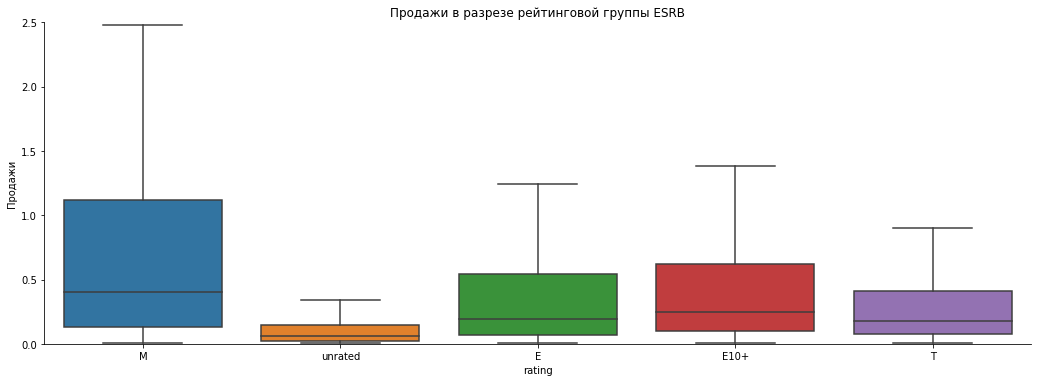

In [ ]:
#Т.к. рейтинги EC и RP не актуальны (есть по 1 шт) уберем их из датафрейма
df_esrb = df_esrb[~df_esrb['rating'].isin(['EC','RP'])]
sns.catplot(data = df_esrb, x = 'rating', y = 'sales_total',kind='box',fliersize = 0,aspect=20/7)

plt.ylim(0,2.5)
plt.ylabel('Продажи')
plt.title('Продажи в разрезе рейтинговой группы ESRB')
plt.show()

* Самые продаваемые игры - игры для взрослых. Все параметры у них высокие. Это говорит о том, что ААА игры делают с акцентом на платежеспособную аудиторию.
* Затем идут 3 группы - E,E10,T - со средним уровнем продаж.
* Аутсайдеры - EC,RP(этот показатель, говорит, что рейтинг только ожидается, поэтому продаж почти нет)

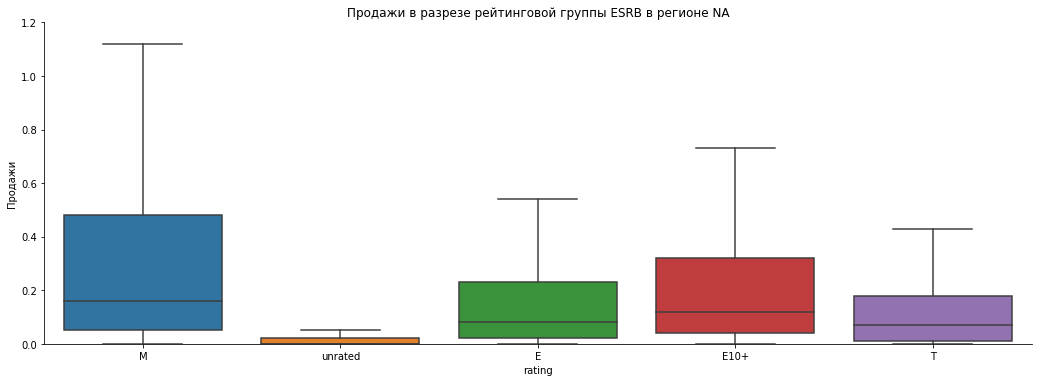

In [ ]:
sns.catplot(data = df_esrb, x = 'rating', y = 'na_sales',kind='box',fliersize = 0,aspect=20/7)

plt.ylim(0,1.2)
plt.ylabel('Продажи')
plt.title('Продажи в разрезе рейтинговой группы ESRB в регионе NA')
plt.show()

* В Америке влияение рейтинга почти аналогично общей картине по всем регионам.  
* Можно только выделить, что продажи Е10 немного выше
* Игры без рейтинга почти не продаются. Возможны 2 варианта: либо их не берут в продажи, либо ESRB покрывает большинство игр.

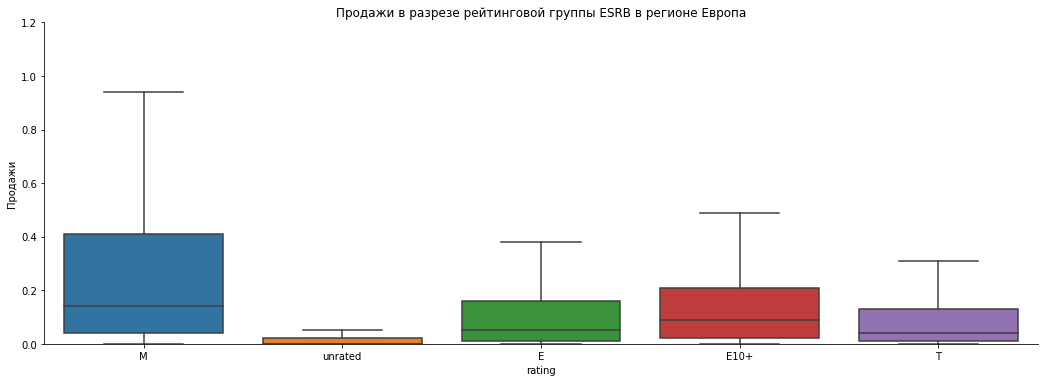

In [ ]:
sns.catplot(data = df_esrb, x = 'rating', y = 'eu_sales',kind='box',fliersize = 0,aspect=20/7)

plt.ylim(0,1.2)
plt.ylabel('Продажи')
plt.title('Продажи в разрезе рейтинговой группы ESRB в регионе Европа')
plt.show()

В Европе сутация аналогичная.

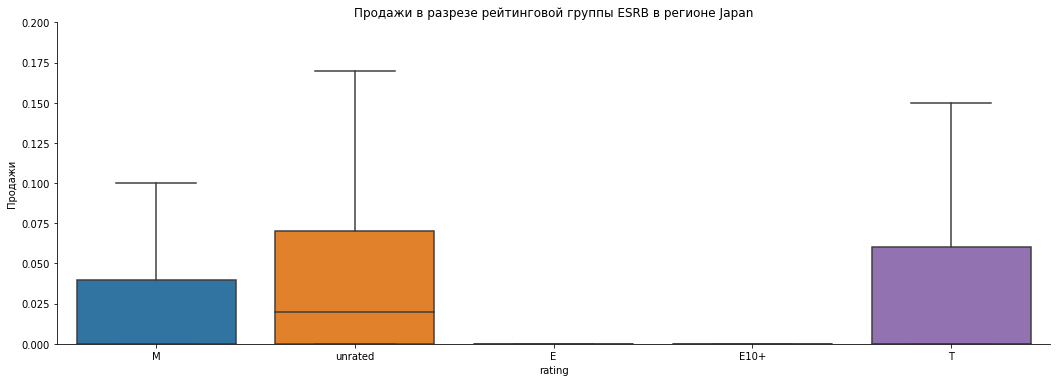

In [ ]:
sns.catplot(data = df_esrb, x = 'rating', y = 'jp_sales',kind='box',fliersize = 0,aspect=20/7)

plt.ylim(0,0.2)
plt.ylabel('Продажи')
plt.title('Продажи в разрезе рейтинговой группы ESRB в регионе Japan')
plt.show()

В Японии используется свой сервис по выставлению рейтингов под названием CERO, поэтому смотреть ESRB для Японии не стоит.
Есть небольшое количество данных в категориях M и T, но скорее всего это те проекты, которые имеют оба рейтинга сразу.

In [ ]:
display('Системы рейтинга CERO в Японии', Image(url='http://u.kanobu.ru/editor/images/86/caafd75d-c422-469e-ae1a-5fe287464338.webp',width = 800))

'Системы рейтинга CERO в Японии'

In [ ]:
# Интересно посмотреть что за игры попали в категорию unrated
df[df['rating']=='unrated'].sort_values('jp_sales', ascending = False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unrated,14.60
385,Monster Hunter 4,3DS,2013,Role-Playing,0.00,0.00,3.44,0.00,NaN,NaN,unrated,3.44
412,Yokai Watch 2 Ganso/Honke,3DS,2014,Role-Playing,0.09,0.00,3.18,0.01,NaN,NaN,unrated,3.28
83,Pokemon Black 2/Pokemon White 2,DS,2012,Role-Playing,2.79,1.72,3.14,0.41,NaN,NaN,unrated,8.06
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unrated,11.68
406,Monster Hunter X,3DS,2015,Action,0.27,0.21,2.79,0.05,NaN,NaN,unrated,3.32
563,Yokai Watch 2 Shinuchi,3DS,2014,Role-Playing,0.00,0.00,2.68,0.00,NaN,NaN,unrated,2.68
96,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,unrated,7.55
694,Yokai Watch Busters,3DS,2015,Action,0.00,0.00,2.29,0.00,NaN,NaN,unrated,2.29
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,unrated,7.14


* В основном игры - не получившие рейтинг - Японские игры, помимо этого видно, что по топ играм нет оценки критиков
* Это во многом объясняет, почему влияние оценки критиков на японскую аудиторию ниже, чем в Европе и Америке

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера V1<a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
В данном пункте нужно рассмотреть игры у которых нет рейтинга, которые ты никак не обработал. Они могут оказать большое влияние на портреты пользователей из определенного региона.
</div>  
<font color = blue> Готово

<div class="alert alert-success">
<h2> Комментарий ревьюера V3<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Прекрасно выполнил данный пункт, все подробно рассмотрел и пришел к верным выводам.

#### Выводы по итогам исследовательского анализав

* По итогам исследовательского анализа мы выяснили:
  1. Средний срок актуальности платформы составляет от 4 до 6 лет.
  2. Игровая индустрия волатильна. Внешние факторы, такие как кризис, могут полностью поменять и количество производимых и гр и их продажи.
  3. Для каждого региона есть отдельные жанры, которые продаются лучше остальных, поэтому стоит ориентироваться на целевую аудиторию при разбивке игр.
  4. Оценки критиков и пользователей оказывают незначительное влияние на продажи, но жанр значительно сильнее влияет на выручку от игры
  5. Рейтинг ESRP в Японии сильно отличается от остальных, игры с рейтингом E и E10 не продаются.

### Проверка гипотез
Для проверки гипотез, мы будем использовать ТТест.  
Т.к. выборки у нас независимые, будем использовать метод ind  
Формируем нулевую гипотезу:
Средние пользовательские оценки XBOX One и PC - одинаковые  
Алтернативная гипотеза - оценки XBOX One и PC - не являются одинаковыми

In [ ]:
#Мы предполагаем, что выборка оценок пользователей для PC - XBOX One одинаковые. Посчитаем вероятность такого события
alpha = 0.05
df_ttest = df_actual.dropna(subset=['user_score'])
results = st.ttest_ind(df_ttest[df_ttest['platform']=='PC']['user_score'], df_ttest[df_ttest['platform']=='XOne']['user_score'],equal_var=False)
print ('P значение =', results.pvalue)

P значение = 0.6130712247638477


Опровергнуть нулевую гипотезу не удалось. Вероятность получить рейтинг в XBOX one такой же как у PC составляет 61%. Это говорит нам о том, нельзя установить значимые отличия между средними оценками пользователей PC и Xbox One

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Все правильно, молодец!

#### Actions vs Sports

Нам нужно проверить, являются ли разными средние пользовательские оценки в жанре Спорт и Экшн.  
Формируем нулевую гипотезу: Оценки в жанрах не отличаются.  
Альтернативная гипотеза: Оценки в жанрах отличаются друг от друга.  
Для проверки как и в первом случае будем использовать ТТест для независимых выборок

In [ ]:
results = st.ttest_ind(df_ttest[df_ttest['genre']=='Action']['user_score'], df_ttest[df_ttest['genre']=='Sports']['user_score'],equal_var=False)
print ('P значение = {}'.format(results.pvalue))

P значение = 8.285648549432565e-19


Вероятность того, что средние оценки жанров не отличаются, крайне мала, т.к. P значение сильно меньше уровня значимости (0.05)  
В данном случае уровень значимости не играет сильной роли, т.к. P значение получилось очень маленьким, почти невозможным.
Опровергаем нулевую гипотезу, а это значит, что средние оценки в жанрах Action и Sports - разные.

<div class="alert alert-success">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> И снова все верно, правильно сформулировал гипотезы и верно их проверил.

#### Выводы по итогам проверки гипотез
В это блоке мы выяснили, что в разных жанрах оценки очень сильно отличаются. Нужно быть готовым заниженным или завышенным оценкам если решим войти в один из особенных жанров.  
При этом сами оценки не сильно влияют на продажи.
А вот оценки на разных платформах часто схожи, поэтому выпустив игру на одной платформе, и получив хорошие оценки, с высокой вероятностью можно получить хорошие оценки на другой.

### Общие выводы по проекту

* Игровая индустрия меняется с высокой скоростью.
* С 2000 года на рынке присутствуют явные компании - лидеры, которые выпускают новые поколения платформ, основная масса актуальных игр выпускается компаниями Sony и Microsoft.
* Самые популярные платформы по продажам: X360, WiiU,XOne,PS3,PS4 
* Срок жизни в лидеров - PS и Xbox выше, чем у остальных.
* Жанр очень сильно играет на продажи игры, а оценки критиков и игроков не так сильно.
* Топ жанр по продажам - Shooter. Со временем стал продаваться гораздо лучше остальных.
* При выборе целевой аудитории стоит ориентироваться на портрет пользователя, который изображен выше.
* В Японии портрет пользователя сильно отличается от Америки и Европы
* Оценки критиков часто влияют на продажи игры, а оценки пользователей - нет.
* Рейнг ESRB актуально смотреть для регионов Европа и Америка. В японии большинство игр не имеют значения по рейтингу ESRB, но у них есть своя система оценки CERO.
* В Европе и Америке очень популярны игры с рейтингом 'M' по версии ESRB, это очень важно для этих регионов.
* Игры для PC остаются актуальными на протяжении всей цепочки, доход от продаж сможет стать неким "постоянным", которая будет снижать волатильность рынка на других платформах.


<div class="alert alert-warning">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> В итоговом выводе нужно достаточно подробно написать основные пункты выявленных зависимостей. Стоит доработать вывод с учетом моих комментариев по ходу работы.  
<font color = blue>Готово. Большое спасибо за обратную связь и полезные советы, которые помогут в дальнейшем. Замечание по читаемости кода также считаю важным, потому что стараюсь это учитывать, поэтому то, что я двигаюсь в этом направлении меня очень обрадовало :)

<div class="alert alert-success">
<h2> Комментарий ревьюера V3<a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Отличный вывод, все четко, понятно и структурировано. Вывод в полной мере отражает существующие зависимости, и по нему можно принимать дальнейшие решения.
</div>

### ЧЕК Лист по задачам из проекта
* [*]Шаг 1. Откройте файл с данными и изучите общую информацию
* [*]Путь к файлу: /datasets/games.csv. Скачать датасет
* [*]Шаг 2. Подготовьте данные
* [*]Замените названия столбцов (приведите к нижнему регистру);
* [*]Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
* [*]Обработайте пропуски при необходимости:
* [*]Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
* [*]Опишите причины, которые могли привести к пропускам;
* [*]Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;
* [*]Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.
* [*]Шаг 3. Проведите исследовательский анализ данных
* [*]Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
* [*]Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
* [*]Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
* [*]Не учитывайте в работе данные за предыдущие годы.
* [*]Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
* [*]Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
* [*]Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
* [*]Соотнесите выводы с продажами игр на других платформах.
* [*]Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?
* [*]Шаг 4. Составьте портрет пользователя каждого региона
* [*]Определите для пользователя каждого региона (NA, EU, JP):
* [*]Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* [*]Самые популярные жанры (топ-5). Поясните разницу.
* [*]Влияет ли рейтинг ESRB на продажи в отдельном регионе?
* [*]Шаг 5. Проверьте гипотезы
* [*]Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* [*]Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
* [*]Задайте самостоятельно пороговое значение alpha.
* [*]Поясните:
* [*]Как вы сформулировали нулевую и альтернативную гипотезы;
* [*]Какой критерий применили для проверки гипотез и почему.
* [*]Шаг 6. Напишите общий вывод
Оформление: Выполните задание в Jupyter Notebook. Заполните программный код в ячейках типа code, текстовые пояснения — в ячейках типа markdown. Примените форматирование и заголовки.
* Описание данных
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
* Данные за 2016 год могут быть неполными.
* Как будут проверять мой проект?
* 💡 Если вашу работу отправили на доработку, пожалуйста, не удаляйте в Jupyter-тетрадке комментарии ревьюера. Так ревьюеру будет проще проверить изменения.
* Мы подготовили критерии оценки проекта. Прежде чем решать кейс, внимательно изучите их.
* На что обращают внимание при проверке проекта:
* Как вы описываете выявленные в данных проблемы?
* Как готовите датасет к анализу?
* Какие строите графики для распределений и как их объясняете?
* Формулируете ли альтернативную и нулевую гипотезы?
* Какие методы применяете, чтобы их проверить?
* Объясняете результат проверки гипотезы или нет?
* Соблюдаете ли структуру проекта и поддерживаете аккуратность кода?
* Какие выводы делаете?
* Оставляете ли комментарии к шагам?
* Всё необходимое, чтобы выполнить проект, есть в шпаргалках и конспектах прошлых тем.
* Успехов!

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**

Спасибо за твой проект! Я уверен, что ты приложил все усилия, чтобы сделать этот проект. Это видно по твоей работе, а сформулированные выводы отражают, насколько успешно ты осваиваешь материал. 

**Отмечу отдельные положительные моменты проекта🙂**:
 
* Ты полностью следовал всем этапам выполнения задания и справился почти со всем. Хорошая работа!
* Отдельно выделю некоторые выводы, которые ты смог сформулировать абсолютно точно!
* У тебя опрятный и читаемый код. Возможно это звучит банально, однако при работе с чужим кодом это крайне важно)


**На что стоит обратить внимание🤓**:
    
* Важно доработать итоговый вывод.
* Нужно корректно обработать все признаки и пропуски в них.
* Необходимо во всех пунктах анализировать только актуальный датафрейм.
* Остальные рекомендации ты найдешь в моих комментариях!


**Желаю удачи и жду твой проект на повторное ревью!**😉

<div style="border:solid Chocolate 2px; padding: 40px">

Ты отлично справился с данной работой! Видно, как ты успешно осваиваешь материал, применяешь полученные знания на практике. Мне было очень приятно проверять твою работу, надеюсь, мои комментарии и советы были для тебя полезными.

**Желаю удачи в последующем обучении и исследованиях!**😉